In [1]:
import os

import json
import pandas as pd
import matplotlib.pyplot as plt

In [135]:
# Assemble all JSON files into a single dataframe
RADEON = 'Radeon RX 6800 XT'
XAVIER = 'Xavier NX'

directories = [
    {'device': RADEON, 'path': os.path.join('..','measurements','20241228-103638860-amd') },
    {'device': XAVIER, 'path': os.path.join('..', '..', '03', 'measurements', '20241228-085104765') }
]

jsonData = []
for entry in directories:
    device = entry['device']
    jsonDirectory = entry['path']
    for filename in os.listdir(jsonDirectory):
        if not filename.endswith('.json'):
            continue
        filePath = os.path.join(jsonDirectory, filename)
        if not os.path.isfile(filePath):
            continue

        with open(filePath, 'r', encoding='utf-8') as file:
            data = json.load(file)
            jsonData.append({
                'device': device,
                'key': os.path.splitext(os.path.basename(filePath))[0],
                'data': data
            })

# Now jsonData is a list of records.

In [253]:
# Create a single Pandas dataframe from the list of records.
def createDfAll():
    def createDataframe(
        sourceKey,
        device,
        kernelKey,
        mappingLetter,
        uniformInput,
        inputFileName,
        inputLengthInCharacters,
        timesTransferToDevice,
        timesExecution,
        timesTransferFromDevice,
        bins
    ):
        n = len(timesExecution)
        df = pd.DataFrame({
            'sourceKey': [sourceKey] * n,
            'device': [device] * n,
            'kernel': [kernelKey] * n,
            'mappingLetter': [mappingLetter] * n,
            'uniformInput': [uniformInput] * n,
            'inputFileName': [inputFileName] * n,
            'inputLengthInCharacters': [inputLengthInCharacters] * n,
            'timeTransferToDevice': timesTransferToDevice,
            'timeExecution': timesExecution,
            'timeTransferFromDevice': timesTransferFromDevice,
            'timeTotal': None,
            'bins': [bins] * n
        })
        df['timeTotal'] = df['timeTransferToDevice'] + df['timeExecution'] + df['timeTransferFromDevice']
        return df

    dfs = []
    for entry in jsonData:
        device = entry['device']
        sourceKey = entry['key']
        rec = entry['data']
        inputLengthInCharacters = rec['inputLengthInCharacters']
        inputFileName = rec.get('fileName')
        uniformInput = rec['uniformInput']
        mappingLetter = rec['useMappingLetter']
        for k in rec['measurements'].keys():
            measurements = rec['measurements'][k]
            dfs.append(createDataframe(
                sourceKey,
                device,
                k,
                mappingLetter,
                uniformInput,
                inputFileName,
                inputLengthInCharacters,
                measurements['timesTransferToDevice'],
                measurements['timesExecution'],
                measurements['timesTransferFromDevice'],
                measurements['bins']
            ))
    return pd.concat(dfs)
dfAll = createDfAll()

In [254]:
dfAll.head()

,sourceKey,device,kernel,mappingLetter,uniformInput,inputFileName,inputLengthInCharacters,timeTransferToDevice,timeExecution,timeTransferFromDevice,timeTotal,bins
0,20241228-103638860-000,Radeon RX 6800 XT,histogram_one_thread_per_character,False,False,./input_data/test.txt,10532866,2.046126,1.044369,0.400534,3.491029,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
1,20241228-103638860-000,Radeon RX 6800 XT,histogram_one_thread_per_character,False,False,./input_data/test.txt,10532866,0.798637,1.039679,0.018920,1.857236,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
2,20241228-103638860-000,Radeon RX 6800 XT,histogram_one_thread_per_character,False,False,./input_data/test.txt,10532866,0.773456,1.039748,0.019281,1.832485,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
3,20241228-103638860-000,Radeon RX 6800 XT,histogram_one_thread_per_character,False,False,./input_data/test.txt,10532866,0.774166,1.041699,0.020640,1.836505,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
4,20241228-103638860-000,Radeon RX 6800 XT,histogram_one_thread_per_character,False,False,./input_data/test.txt,10532866,0.774926,1.040709,0.020280,1.835915,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."


In [255]:
def getMeasurementsFor(
    df,
    device,
    mapping,
    inputType,
    kernels = None
):
    boolDevice = df['device'] == device
    if kernels is None:
        boolKernel = [True] * len(df['kernel'])
    else:
        if not isinstance(kernel, list):
            kernels = [kernels]
        boolKernel = df['kernel'].isin(kernels)
    if mapping == 'Mapping128':
        boolMapping = (df['mappingLetter'] == False)
    elif mapping == 'MappingLetter':
        boolMapping = (df['mappingLetter'] == True)
    else:
        raise RuntimeError('invalid mapping')
    if inputType == 'testfile':
        boolInputType = (df['inputFileName'].notna())
    elif inputType == 'uniform':
        boolInputType = (df['uniformInput'] == True) * (df['inputFileName'].isna())
    elif inputType == 'pseudorandom':
        boolInputType = (df['uniformInput'] == False) * (df['inputFileName'].isna())
    else:
        raise RuntimeError('invalid inputType')
    return df[boolDevice * boolKernel * boolMapping * boolInputType]

In [256]:
getMeasurementsFor(dfAll, RADEON, 'Mapping128', 'testfile', kernels=None)

,sourceKey,device,kernel,mappingLetter,uniformInput,inputFileName,inputLengthInCharacters,timeTransferToDevice,timeExecution,timeTransferFromDevice,timeTotal,bins
0,20241228-103638860-000,Radeon RX 6800 XT,histogram_one_thread_per_character,False,False,./input_data/test.txt,10532866,2.046126,1.044369,0.400534,3.491029,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
1,20241228-103638860-000,Radeon RX 6800 XT,histogram_one_thread_per_character,False,False,./input_data/test.txt,10532866,0.798637,1.039679,0.018920,1.857236,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
2,20241228-103638860-000,Radeon RX 6800 XT,histogram_one_thread_per_character,False,False,./input_data/test.txt,10532866,0.773456,1.039748,0.019281,1.832485,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
3,20241228-103638860-000,Radeon RX 6800 XT,histogram_one_thread_per_character,False,False,./input_data/test.txt,10532866,0.774166,1.041699,0.020640,1.836505,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
4,20241228-103638860-000,Radeon RX 6800 XT,histogram_one_thread_per_character,False,False,./input_data/test.txt,10532866,0.774926,1.040709,0.020280,1.835915,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
95,20241228-103638860-000,Radeon RX 6800 XT,histogram_atomic_private_stride,False,False,./input_data/test.txt,10532866,0.758496,0.067631,0.023780,0.849907,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
96,20241228-103638860-000,Radeon RX 6800 XT,histogram_atomic_private_stride,False,False,./input_data/test.txt,10532866,0.758506,0.069191,0.020680,0.848377,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
97,20241228-103638860-000,Radeon RX 6800 XT,histogram_atomic_private_stride,False,False,./input_data/test.txt,10532866,0.758026,0.069661,0.019520,0.847207,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
98,20241228-103638860-000,Radeon RX 6800 XT,histogram_atomic_private_stride,False,False,./input_data/test.txt,10532866,0.758326,0.069180,0.021560,0.849066,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."


## Measurement results for test input file

In [257]:
dfTestFile = dfAll[dfAll['inputFileName'].notna()]

Number of characters in the test input file:

In [258]:
s = set(dfTestFile['inputLengthInCharacters'])
if len(s) != 1:
    raise RuntimeError('Something is wrong')
list(s)[0]

10532866

Distribution of characters in the test input file (bin counts under `Mapping128`):

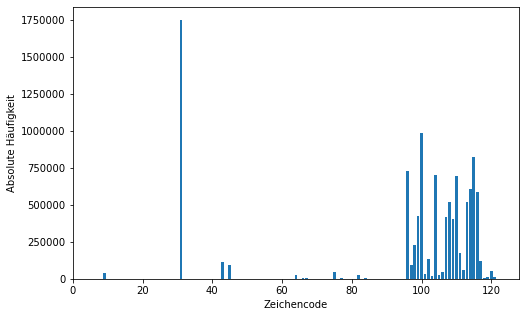

In [259]:
binCounts = dfTestFile.iloc[0]['bins']

fig = plt.figure(figsize=(8,5))
plt.bar(list(range(0,len(binCounts))), binCounts)
plt.xlim(0, len(binCounts))
fig.axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.xlabel('Zeichencode')
plt.ylabel('Absolute Häufigkeit')
plt.show()

TODO (evtl.): Tabelle mit den Häufigkeiten der einzelnen Zeichen

Statistik:

In [260]:
def testFileMakeStatistics(mapping):
    if mapping == 'Mapping128':
        boolMapping = dfTestFile['mappingLetter'] == False
    elif mapping == 'MappingLetter':
        boolMapping = dfTestFile['mappingLetter'] == True
    return dfTestFile[boolMapping].groupby(['device', 'kernel'])[
        ['timeTransferToDevice', 'timeExecution', 'timeTransferFromDevice', 'timeTotal']
    ].agg([
        ('min', lambda x: x.min()),
        ('q10', lambda x: x.quantile(0.1)),
        ('med', lambda x: x.median()),
        ('q90', lambda x: x.quantile(0.5)),
        ('max', lambda x: x.max())
    ])

In [261]:
stat128 = testFileMakeStatistics('Mapping128')
stat128

timeTransferToDevice  \
                                                                      min   
device            kernel                                                    
Radeon RX 6800 XT histogram_atomic_private                       0.657416   
                  histogram_atomic_private_stride                0.653225   
                  histogram_one_thread_per_character             0.658406   
Xavier NX         histogram_atomic_private                       1.493152   
                  histogram_atomic_private_stride                1.397024   
                  histogram_one_thread_per_character             1.844384   

                                                                          \
                                                           q10       med   
device            kernel                                                   
Radeon RX 6800 XT histogram_atomic_private            0.658407  0.759041   
                  histogram_atomic_private_stride     0.658267  0.758506   
                  histogram_one_thread_per_character  0.672192  0.772211   
Xavier NX         histogram_atomic_private            1.590579  1.822656   
                  histogram_atomic_private_stride     1.429530  1.500000   
                  histogram_one_thread_per_character  1.907744  2.032912   

                                                                          \
                                                           q90       max   
device            kernel                                                   
Radeon RX 6800 XT histogram_atomic_private            0.759041  1.657092   
                  histogram_atomic_private_stride     0.758506  1.651754   
                  histogram_one_thread_per_character  0.772211  2.046126   
Xavier NX         histogram_atomic_private            1.822656  2.188544   
                  histogram_atomic_private_stride     1.500000  2.143232   
                  histogram_one_thread_per_character  2.032912  2.381568   

                                                     timeExecution            \
                                                               min       q10   
device            kernel                                                       
Radeon RX 6800 XT histogram_atomic_private                0.114161  0.114984   
                  histogram_atomic_private_stride         0.063121  0.067410   
                  histogram_one_thread_per_character      1.039448  1.039687   
Xavier NX         histogram_atomic_private                2.028000  2.049795   
                  histogram_atomic_private_stride         1.020960  1.039398   
                  histogram_one_thread_per_character      9.502912  9.534061   

                                                                          \
                                                           med       q90   
device            kernel                                                   
Radeon RX 6800 XT histogram_atomic_private            0.116106  0.116106   
                  histogram_atomic_private_stride     0.068280  0.068280   
                  histogram_one_thread_per_character  1.039939  1.039939   
Xavier NX         histogram_atomic_private            2.087696  2.087696   
                  histogram_atomic_private_stride     1.059328  1.059328   
                  histogram_one_thread_per_character  9.575264  9.575264   

                                                                \
                                                           max   
device            kernel                                         
Radeon RX 6800 XT histogram_atomic_private            0.131731   
                  histogram_atomic_private_stride     0.069661   
                  histogram_one_thread_per_character  1.045578   
Xavier NX         histogram_atomic_private            2.272672   
                  histogram_atomic_private_stride     1.193312   
                  histogram_one_thread_per_character  9

In [262]:
statLetter = testFileMakeStatistics('MappingLetter')
statLetter

timeTransferToDevice  \
                                                                      min   
device            kernel                                                    
Radeon RX 6800 XT histogram_atomic_private                       0.640695   
                  histogram_atomic_private_stride                0.636956   
                  histogram_one_thread_per_character             0.642675   
Xavier NX         histogram_atomic_private                       1.458592   
                  histogram_atomic_private_stride                1.488416   
                  histogram_one_thread_per_character             1.833760   

                                                                          \
                                                           q10       med   
device            kernel                                                   
Radeon RX 6800 XT histogram_atomic_private            0.642994  0.646770   
                  histogram_atomic_private_stride     0.638512  0.642060   
                  histogram_one_thread_per_character  0.656984  0.660300   
Xavier NX         histogram_atomic_private            1.568829  1.850112   
                  histogram_atomic_private_stride     1.735840  1.876240   
                  histogram_one_thread_per_character  1.888947  1.987616   

                                                                          \
                                                           q90       max   
device            kernel                                                   
Radeon RX 6800 XT histogram_atomic_private            0.646770  1.555912   
                  histogram_atomic_private_stride     0.642060  1.555041   
                  histogram_one_thread_per_character  0.660300  2.109356   
Xavier NX         histogram_atomic_private            1.850112  2.257184   
                  histogram_atomic_private_stride     1.876240  2.079584   
                  histogram_one_thread_per_character  1.987616  2.206624   

                                                     timeExecution             \
                                                               min        q10   
device            kernel                                                        
Radeon RX 6800 XT histogram_atomic_private                0.115561   0.116281   
                  histogram_atomic_private_stride         0.068081   0.069876   
                  histogram_one_thread_per_character      1.280952   1.281257   
Xavier NX         histogram_atomic_private                2.066880   2.084608   
                  histogram_atomic_private_stride         1.072928   1.094442   
                  histogram_one_thread_per_character     11.273024  11.287712   

                                                                            \
                                                            med        q90   
device            kernel                                                     
Radeon RX 6800 XT histogram_atomic_private             0.118146   0.118146   
                  histogram_atomic_private_stride      0.071426   0.071426   
                  histogram_one_thread_per_character   1.281632   1.281632   
Xavier NX         histogram_atomic_private             2.105360   2.105360   
                  histogram_atomic_private_stride      1.119776   1.119776   
                  histogram_one_thread_per_character  11.348416  11.348416   

                                                                 \
                                                            max   
device            kernel                                          
Radeon RX 6800 XT histogram_atomic_private             0.123421   
                  histogram_atomic_private_stride      0.077211   
                  histogram_one_thread_per_character   1.366031   
Xavier NX         histogram_atomic_private             2.273408   
                  histogram_atomic_private_stride      1.220992   
                  hi

Ausführungszeiten für die einzelnen Kernels für die beiden Mappings:

In [263]:
data1 = stat128['timeExecution']['med']
data2 = statLetter['timeExecution']['med']

data1.index = pd.MultiIndex.from_tuples([(x, 'Mapping128', z) for x, z in data1.index], names=['device', 'mapping', 'kernel'])
data2.index = pd.MultiIndex.from_tuples([(x, 'MappingLetter', z) for x, z in data2.index], names=['device', 'mapping', 'kernel'])
s = pd.concat([data1, data2]).sort_index(level=0).unstack(level=1).unstack(level=1)
s

mapping                         Mapping128                                  \
kernel            histogram_atomic_private histogram_atomic_private_stride   
device                                                                       
Radeon RX 6800 XT                 0.116106                        0.068280   
Xavier NX                         2.087696                        1.059328   

mapping                                                         MappingLetter  \
kernel            histogram_one_thread_per_character histogram_atomic_private   
device                                                                          
Radeon RX 6800 XT                           1.039939                 0.118146   
Xavier NX                                   9.575264                 2.105360   

mapping                                            \
kernel            histogram_atomic_private_stride   
device                                              
Radeon RX 6800 XT                        0.071426   
Xavier NX                                1.119776   

mapping                                               
kernel            histogram_one_thread_per_character  
device                                                
Radeon RX 6800 XT                           1.281632  
Xavier NX                                  11.348416

Speedup in den Ausführungszeiten:

In [264]:
OTPC = 'histogram_one_thread_per_character'
dd = s.copy() # probably inefficient way of copying the layout of the dataframe
for m in set(s.columns.get_level_values(0)):
    n = s[(m, OTPC)]
    for h in set(s.columns.get_level_values(1)):
        dd[(m, h)] = n / s[(m, h)]
dd

mapping                         Mapping128                                  \
kernel            histogram_atomic_private histogram_atomic_private_stride   
device                                                                       
Radeon RX 6800 XT                 8.956807                       15.230395   
Xavier NX                         4.586522                        9.038998   

mapping                                                         MappingLetter  \
kernel            histogram_one_thread_per_character histogram_atomic_private   
device                                                                          
Radeon RX 6800 XT                                1.0                10.847866   
Xavier NX                                        1.0                 5.390250   

mapping                                            \
kernel            histogram_atomic_private_stride   
device                                              
Radeon RX 6800 XT                       17.943494   
Xavier NX                               10.134541   

mapping                                               
kernel            histogram_one_thread_per_character  
device                                                
Radeon RX 6800 XT                                1.0  
Xavier NX                                        1.0

Untersuchung der Transferzeiten auf das Device:

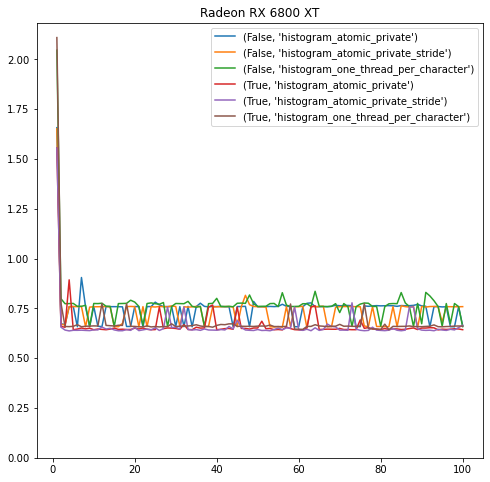

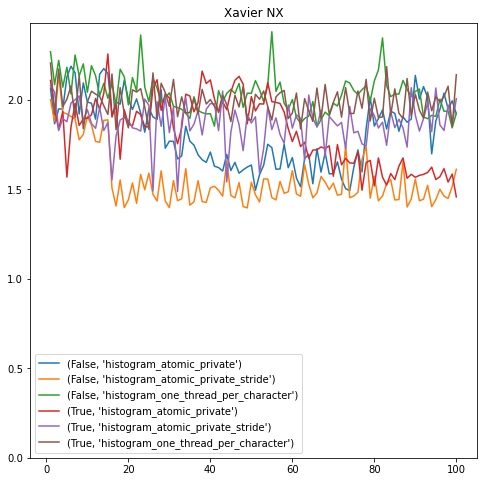

In [265]:
for device, grp in dfTestFile.groupby(['device']):
    plt.subplots(figsize=(8,8))
    plt.title(device)
    grouped = grp.groupby(['mappingLetter', 'kernel'])
    for name, group in grouped:
        c = group['timeTransferToDevice']
        plt.plot(range(1,len(c)+1),c, label=name)
    plt.ylim(0)
    plt.legend()
    plt.show()

In [266]:
# Analyse execution times

dfFiltered = df[df['itemMeasured'] == 'timesExecution']
grouped = dfFiltered.groupby('kernel')

def scatterPlotForGroup(groupName):
    ddf = grouped.get_group(groupName)
    
    plt.figure(figsize=(4,3))
    plt.scatter(ddf['inputLengthInCharacters'], ddf['time'], s=3)
    plt.xscale('log', base=2)
    plt.yscale('log', base=10)
    plt.show()

scatterPlotForGroup('histogram_one_thread_per_character')

KeyError: 'itemMeasured'

In [5]:
def statisticsForGroup(groupName):
    ddf = grouped.get_group(groupName)
    
    return ddf.groupby('inputLengthInCharacters')['time'].agg(
        average='mean',
        std_dev='std',
        min='min',
        max='max',
        first_decile=lambda x: x.quantile(0.1),
        last_decile=lambda x: x.quantile(0.9),
        median=lambda x: x.quantile(0.5)
    ).reset_index()

statistics = statisticsForGroup('histogram_one_thread_per_character')

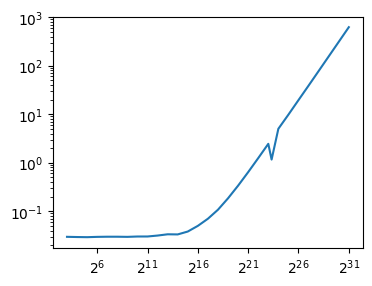

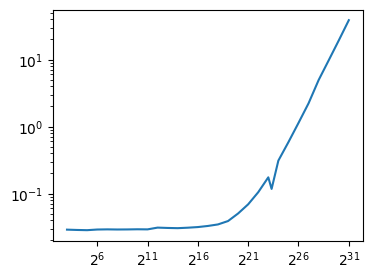

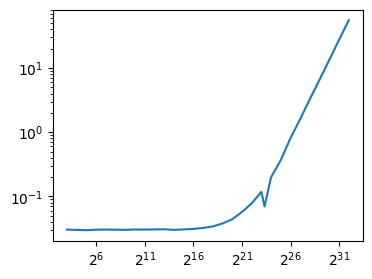

In [6]:
def lineGraphForGroup(groupName):
    statistics = statisticsForGroup(groupName)
    
    plt.figure(figsize=(4,3))
    plt.plot(statistics['inputLengthInCharacters'], statistics['average'])
    plt.xscale('log', base=2)
    plt.yscale('log', base=10)
    plt.show()

lineGraphForGroup('histogram_one_thread_per_character')
lineGraphForGroup('histogram_atomic_private')
lineGraphForGroup('histogram_atomic_private_stride')

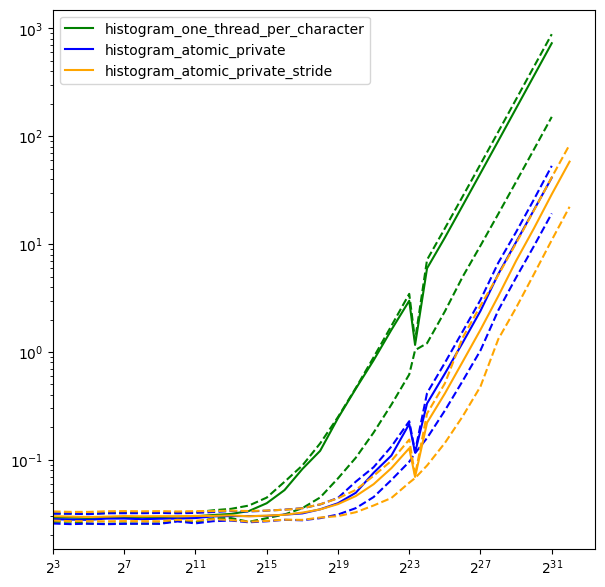

In [7]:
def lineGraphForAll():
    kernelNames = ['histogram_one_thread_per_character', 'histogram_atomic_private', 'histogram_atomic_private_stride']
    col = {
        'histogram_one_thread_per_character': 'green',
        'histogram_atomic_private': 'blue',
        'histogram_atomic_private_stride': 'orange'
    }
    s = {}
    for k in kernelNames:
        s[k] = statisticsForGroup(k)

    plt.figure(figsize=(7,7))
    for k in kernelNames:
        plt.plot(s[k]['inputLengthInCharacters'], s[k]['last_decile'], color=col[k], linestyle='--')
        plt.plot(s[k]['inputLengthInCharacters'], s[k]['median'], label=k, color=col[k])
        plt.plot(s[k]['inputLengthInCharacters'], s[k]['first_decile'], color=col[k], linestyle='--')
    plt.xscale('log', base=2)
    plt.yscale('log', base=10)
    plt.xlim(2 ** 3)
    plt.legend()
    plt.show()

lineGraphForAll()

In [8]:
df[(df['kernel'] == 'histogram_atomic_private') * (df['inputLengthInCharacters'] == 2**22) * (df['itemMeasured'] == 'timesExecution')]

,inputLengthInCharacters,kernel,itemMeasured,time
0,4194304,histogram_atomic_private,timesExecution,0.850688
1,4194304,histogram_atomic_private,timesExecution,0.824896
2,4194304,histogram_atomic_private,timesExecution,0.832672
3,4194304,histogram_atomic_private,timesExecution,0.862944
4,4194304,histogram_atomic_private,timesExecution,0.822208
...,...,...,...,...
95,4194304,histogram_atomic_private,timesExecution,0.818976
96,4194304,histogram_atomic_private,timesExecution,0.843648
97,4194304,histogram_atomic_private,timesExecution,0.869280
98,4194304,histogram_atomic_private,timesExecution,0.820960


In [9]:
df

,inputLengthInCharacters,kernel,itemMeasured,time
0,4096,histogram_one_thread_per_character,timesTransferToDevice,0.100480
1,4096,histogram_one_thread_per_character,timesTransferToDevice,0.053280
2,4096,histogram_one_thread_per_character,timesTransferToDevice,0.047744
3,4096,histogram_one_thread_per_character,timesTransferToDevice,0.165760
4,4096,histogram_one_thread_per_character,timesTransferToDevice,0.046816
...,...,...,...,...
95,16,histogram_atomic_private_stride,timesTransferFromDevice,0.039200
96,16,histogram_atomic_private_stride,timesTransferFromDevice,0.038720
97,16,histogram_atomic_private_stride,timesTransferFromDevice,0.086048
98,16,histogram_atomic_private_stride,timesTransferFromDevice,0.075712


## Measurement results for generated data

In [267]:
dfGenerated = dfAll[dfAll['inputFileName'].isna()]

Distribution of characters for input size of 2^30 (= 1 GiB):

In [268]:
counts = dfGenerated[
    (dfGenerated['inputLengthInCharacters']==2**30) *
    (dfGenerated['uniformInput'] == False)
]['bins'].iloc[0]
print('rel. dev. ', (max(counts) - min(counts)) / sum(counts))

rel. dev.  9.28528606891632e-06


In [307]:
def generatedMakeStatistics(mapping):
    if mapping == 'Mapping128':
        boolMapping = dfGenerated['mappingLetter'] == False
    elif mapping == 'MappingLetter':
        boolMapping = dfGenerated['mappingLetter'] == True
    else:
        raise RuntimeError('Invalid parameter value: mapping')
    #boolUniform = dfGenerated['uniformInput'] == uniform
    return dfGenerated[
        boolMapping #* boolUniform
    ].groupby(['device', 'uniformInput', 'inputLengthInCharacters', 'kernel'])[
        ['timeTransferToDevice', 'timeExecution', 'timeTransferFromDevice', 'timeTotal']
    ].agg([
        ('min', lambda x: x.min()),
        ('q10', lambda x: x.quantile(0.1)),
        ('med', lambda x: x.median()),
        ('q90', lambda x: x.quantile(0.5)),
        ('max', lambda x: x.max())
    ])

In [308]:
genStat = generatedMakeStatistics('Mapping128')
genStat

timeTransferToDevice  \
                                                                                                           min   
device            uniformInput inputLengthInCharacters kernel                                                    
Radeon RX 6800 XT False        8                       histogram_atomic_private                       0.019560   
                                                       histogram_atomic_private_stride                0.018480   
                                                       histogram_one_thread_per_character             0.022640   
                               16                      histogram_atomic_private                       0.016840   
                                                       histogram_atomic_private_stride                0.016920   
...                                                                                                        ...   
Xavier NX         True         1073741824              histogram_one_thread_per_character           146.395065   
                               2147483648              histogram_atomic_private                     280.029022   
                                                       histogram_atomic_private_stride              280.293976   
                                                       histogram_one_thread_per_character           280.792084   
                               4294967296              histogram_atomic_private_stride              570.173218   

                                                                                                       \
                                                                                                  q10   
device            uniformInput inputLengthInCharacters kernel                                           
Radeon RX 6800 XT False        8                       histogram_atomic_private              0.022974   
                                                       histogram_atomic_private_stride       0.022872   
                                                       histogram_one_thread_per_character    0.023397   
                               16                      histogram_atomic_private              0.021712   
                                                       histogram_atomic_private_stride       0.022881   
...                                                                                               ...   
Xavier NX         True         1073741824              histogram_one_thread_per_character  147.995345   
                               2147483648              histogram_atomic_private            280.472058   
                                                       histogram_atomic_private_stride     280.873270   
                                                       histogram_one_thread_per_character  292.470673   
                               4294967296              histogram_atomic_private_stride     571.883691   

                                                                                                       \
                                                                                                  med   
device            uniformInput inputLengthInCharacters kernel                                           
Radeon RX 6800 XT False        8                       histogram_atomic_private              0.024986   
                                                       histogram_atomic_private_stride       0.025515   
                                                       histogram_one_thread_per_character    0.025510   
                               16                      histogram_atomic_private              0.024451   
                                                       histogram_atomic_private_stride       0.024380   
...                                                                                               ...   
Xavier NX         True         1073741824              histogram_one_thread_p

In [309]:
def generatedCreatePlots(genState):
    grouped = genStat.reset_index().groupby('device')

    col = {
        (False, 'histogram_one_thread_per_character'): 'green',
        (True, 'histogram_one_thread_per_character'): 'darkgreen',
        (False, 'histogram_atomic_private'): 'blue',
        (True, 'histogram_atomic_private'): 'darkblue',
        (False, 'histogram_atomic_private_stride'): 'orange',
        (True, 'histogram_atomic_private_stride'): 'orange',
    }

    for device, grp in grouped:
        plt.figure(figsize=(7,7))
        by_kernel = grp.groupby(['uniformInput', 'kernel'])
        for (uniform, kernel), g in by_kernel:
            plt.plot(g['inputLengthInCharacters'], g[('timeExecution', 'q10')], color=col[(uniform, kernel)], linestyle='--')
            plt.plot(g['inputLengthInCharacters'], g[('timeExecution', 'med')], color=col[(uniform, kernel)])
            plt.plot(g['inputLengthInCharacters'], g[('timeExecution', 'q90')], color=col[(uniform, kernel)], linestyle='--')
        plt.xscale('log', base=2)
        plt.yscale('log', base=10)
        plt.xlim(2 ** 3)
        plt.ylim(10 ** -2, 10 ** 3.7)
        plt.title(device)
        plt.show()

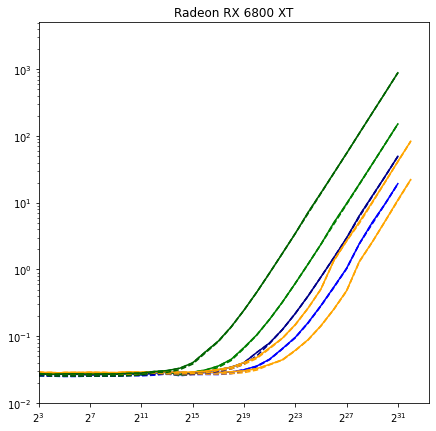

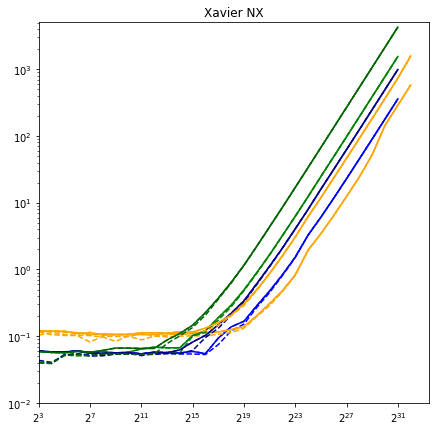

In [310]:
generatedCreatePlots(genStat)

In [311]:
genStat = generatedMakeStatistics('MappingLetter')
genStat

timeTransferToDevice  \
                                                                                                           min   
device            uniformInput inputLengthInCharacters kernel                                                    
Radeon RX 6800 XT False        8                       histogram_atomic_private                       0.017161   
                                                       histogram_atomic_private_stride                0.022451   
                                                       histogram_one_thread_per_character             0.020880   
                               16                      histogram_atomic_private                       0.016720   
                                                       histogram_atomic_private_stride                0.020960   
...                                                                                                        ...   
Xavier NX         True         1073741824              histogram_one_thread_per_character           142.784668   
                               2147483648              histogram_atomic_private                     290.539947   
                                                       histogram_atomic_private_stride              277.471435   
                                                       histogram_one_thread_per_character           294.943817   
                               4294967296              histogram_atomic_private_stride              569.901550   

                                                                                                       \
                                                                                                  q10   
device            uniformInput inputLengthInCharacters kernel                                           
Radeon RX 6800 XT False        8                       histogram_atomic_private              0.024598   
                                                       histogram_atomic_private_stride       0.024691   
                                                       histogram_one_thread_per_character    0.025040   
                               16                      histogram_atomic_private              0.023270   
                                                       histogram_atomic_private_stride       0.022219   
...                                                                                               ...   
Xavier NX         True         1073741824              histogram_one_thread_per_character  144.040559   
                               2147483648              histogram_atomic_private            291.261325   
                                                       histogram_atomic_private_stride     278.452014   
                                                       histogram_one_thread_per_character  295.312476   
                               4294967296              histogram_atomic_private_stride     577.742835   

                                                                                                       \
                                                                                                  med   
device            uniformInput inputLengthInCharacters kernel                                           
Radeon RX 6800 XT False        8                       histogram_atomic_private              0.025490   
                                                       histogram_atomic_private_stride       0.025290   
                                                       histogram_one_thread_per_character    0.025790   
                               16                      histogram_atomic_private              0.024910   
                                                       histogram_atomic_private_stride       0.024665   
...                                                                                               ...   
Xavier NX         True         1073741824              histogram_one_thread_p

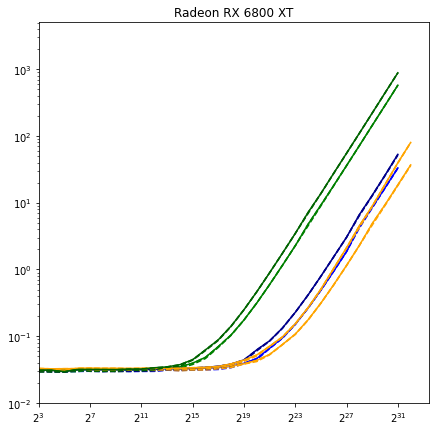

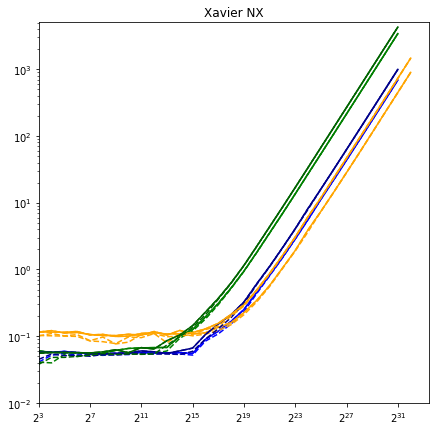

In [312]:
generatedCreatePlots(genStat)